# Bayesian Ridge Regression

# References 

* http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information matplotlib, numpy, pandas, pymc3, seaborn, sklearn, theano

Software,Version
Python,3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,4.1.2
OS,Linux 3.13.0 86 generic x86_64 with debian jessie sid
matplotlib,1.5.1
numpy,1.10.4
pandas,0.18.0
pymc3,3.0
seaborn,0.7.0
sklearn,0.17.1
theano,0.9.0dev1.dev-5e50147375ad507990655cc1a3e990aa4c190549


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import preprocessing as preproc
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae
import theano
from theano import tensor as T

#pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)
sns.set()

In [4]:
path = '../btc-data/BTC_LOB_features_10s.csv'
data = pd.read_csv(path, index_col = 0, parse_dates = True)

# Data Preprocessing

In [5]:
X, y = data, data['mid price'].copy()

for df in X.columns.tolist():
    X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))
    
train_dates = X.index[:int(0.7*len(X))]
test_dates = X.index[int(0.7*len(X)):]

#X_train[train_dates[0] : train_dates[-361]] = [X[i : i + 360] for i in range(len(X[:-360]))]
#X_test = X[test_dates[0] : test_dates[-361]]
#y_train = y[train_dates[360] : train_dates[-1]]
#y_test = y[test_dates[360] : test_dates[-361]]

In [6]:
print('First training date: ', train_dates[0])
print('Last training date: ', train_dates[-1])
print('First testing date: ', test_dates[0])
print('Last testing date: ', test_dates[-1])

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:29:50
First testing date:  2016-03-25 17:30:00
Last testing date:  2016-05-01 00:59:50


# Create DataFrames for the training set. Input: mid prices from the previous hour, output: mid price change in the next 10 seconds.

In [6]:
X_train = pd.DataFrame()
y_train = y[train_dates[360] : train_dates[-1]]

for i in range(360):
    colname = 'mid price ' + str(i + 1)
    X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 360)].values
    
X_train.set_index(train_dates[360:])

                     mid price 1  mid price 2  mid price 3  mid price 4  \
2016-01-01 01:00:00     0.651821     0.651821     0.652255     0.652905   
2016-01-01 01:00:10     0.651821     0.652255     0.652905     0.653122   
2016-01-01 01:00:20     0.652255     0.652905     0.653122     0.653122   
2016-01-01 01:00:30     0.652905     0.653122     0.653122     0.653122   
2016-01-01 01:00:40     0.653122     0.653122     0.653122     0.653122   
2016-01-01 01:00:50     0.653122     0.653122     0.653122     0.653339   
2016-01-01 01:01:00     0.653122     0.653122     0.653339     0.653556   
2016-01-01 01:01:10     0.653122     0.653339     0.653556     0.653773   
2016-01-01 01:01:20     0.653339     0.653556     0.653773     0.653773   
2016-01-01 01:01:30     0.653556     0.653773     0.653773     0.654207   
2016-01-01 01:01:40     0.653773     0.653773     0.654207     0.655292   
2016-01-01 01:01:50     0.653773     0.654207     0.655292     0.655726   
2016-01-01 01:02:00     0

In [8]:
clf = BayesianRidge(compute_score=True)
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

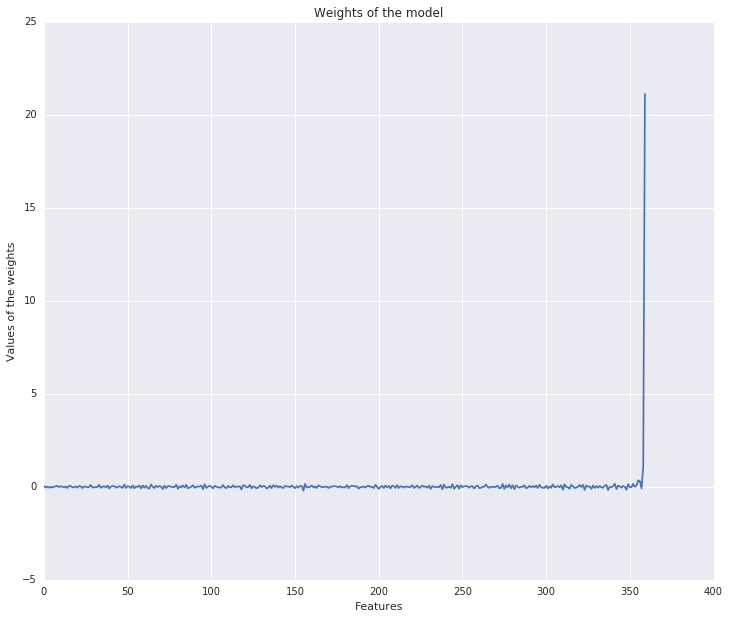

In [9]:
plt.figure(figsize=(12, 10))
plt.title("Weights of the model")
plt.plot(clf.coef_, label="Bayesian Ridge estimate")
plt.xlabel("Features")
plt.ylabel("Weights")

In [10]:
X_test = pd.DataFrame()
y_test = y[test_dates[360] : test_dates[-1]]

for i in range(360):
    colname = 'mid price ' + str(i + 1)
    X_test[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(test_dates) + i - 360)].values

X_test.set_index(test_dates[360:])

                     mid price 1  mid price 2  mid price 3  mid price 4  \
2016-03-25 18:30:00     0.027636     0.027636     0.029155     0.033711   
2016-03-25 18:30:10     0.027636     0.029155     0.033711     0.033711   
2016-03-25 18:30:20     0.029155     0.033711     0.033711     0.033711   
2016-03-25 18:30:30     0.033711     0.033711     0.033711     0.033711   
2016-03-25 18:30:40     0.033711     0.033711     0.033711     0.028504   
2016-03-25 18:30:50     0.033711     0.033711     0.028504     0.028504   
2016-03-25 18:31:00     0.033711     0.028504     0.028504     0.027202   
2016-03-25 18:31:10     0.028504     0.028504     0.027202     0.027636   
2016-03-25 18:31:20     0.028504     0.027202     0.027636     0.029589   
2016-03-25 18:31:30     0.027202     0.027636     0.029589     0.029589   
2016-03-25 18:31:40     0.027636     0.029589     0.029589     0.039352   
2016-03-25 18:31:50     0.029589     0.029589     0.039352     0.039135   
2016-03-25 18:32:00     0

In [11]:
pred = clf.predict(X_test)
pd.DataFrame(pred, index = test_dates[360:])

                              0
2016-03-25 18:30:00  415.956708
2016-03-25 18:30:10  415.987729
2016-03-25 18:30:20  415.992998
2016-03-25 18:30:30  415.995695
2016-03-25 18:30:40  416.127079
2016-03-25 18:30:50  416.172268
2016-03-25 18:31:00  416.185434
2016-03-25 18:31:10  416.174307
2016-03-25 18:31:20  416.204017
2016-03-25 18:31:30  416.213345
2016-03-25 18:31:40  416.252431
2016-03-25 18:31:50  416.273035
2016-03-25 18:32:00  416.281720
2016-03-25 18:32:10  416.290382
2016-03-25 18:32:20  416.290179
2016-03-25 18:32:30  416.295518
2016-03-25 18:32:40  416.237369
2016-03-25 18:32:50  416.243281
2016-03-25 18:33:00  416.245258
2016-03-25 18:33:10  416.243046
2016-03-25 18:33:20  416.246837
2016-03-25 18:33:30  416.307392
2016-03-25 18:33:40  416.327328
2016-03-25 18:33:50  416.313306
2016-03-25 18:34:00  416.316537
2016-03-25 18:34:10  416.320546
2016-03-25 18:34:20  416.332150
2016-03-25 18:34:30  416.344337
2016-03-25 18:34:40  416.315066
2016-03-25 18:34:50  416.314629
...     

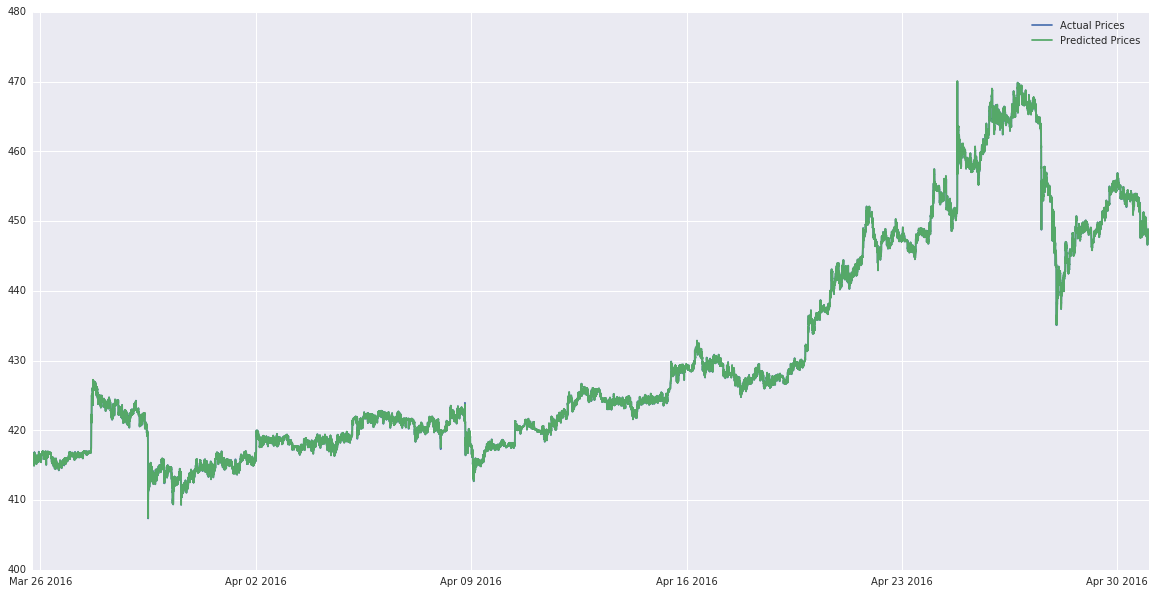

In [12]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
plt.legend()

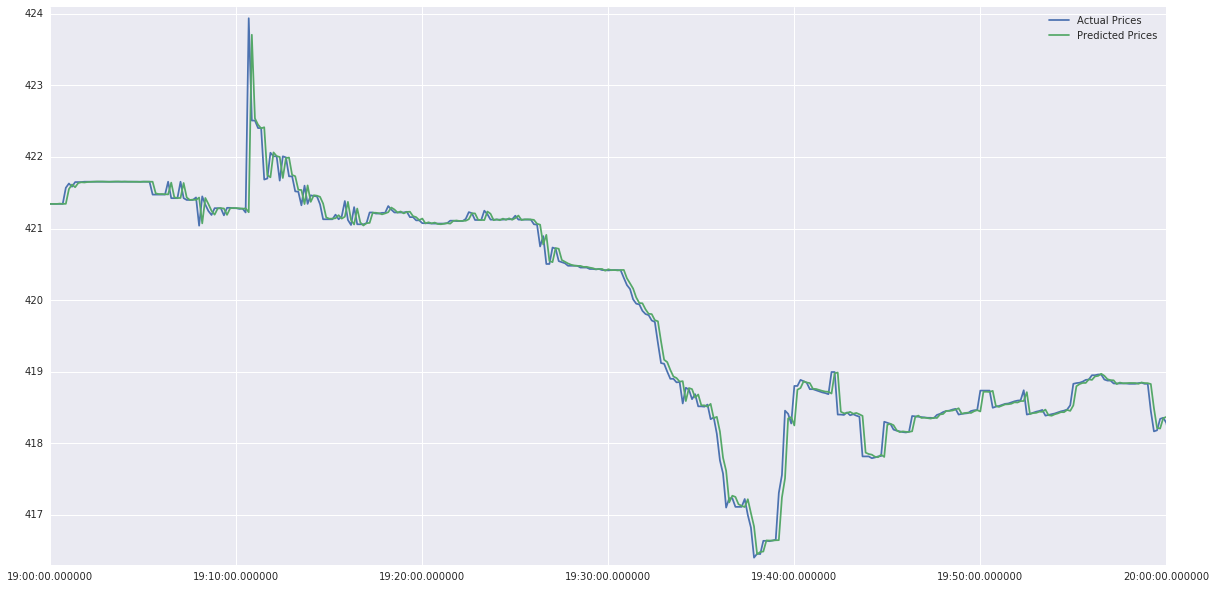

In [21]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
plt.xlim('2016-04-08 19', '2016-04-08 20')
plt.ylim(416.3, 424.1)
plt.legend()

In [22]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

0.093629886478
0.129202324923


In [23]:
act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
accuracy = np.sum(act_pred_cmp) / len(act_ticks)
accuracy

0.52629244461179592

In [26]:
for c in X.drop('mid price', axis = 1).columns.tolist():
    X_train[c] = X[c].ix[359 : len(train_dates) - 1].values

In [29]:
clf = BayesianRidge(compute_score=True)
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

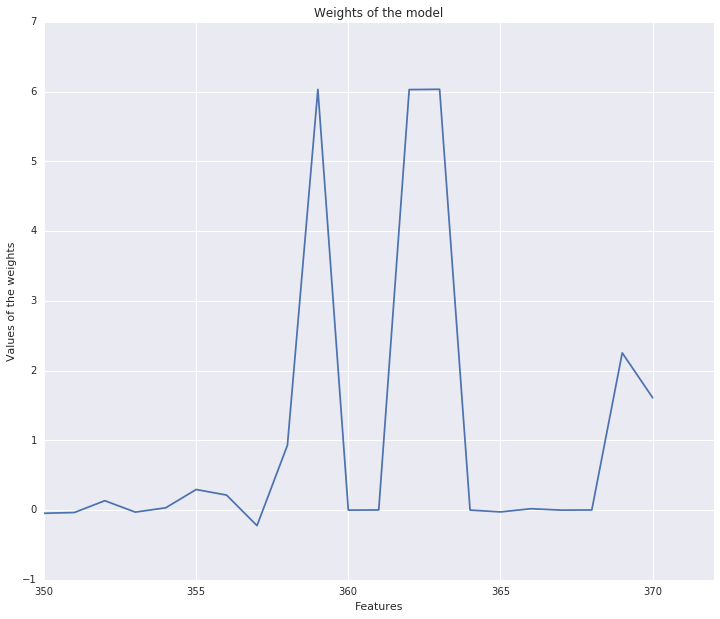

In [38]:
plt.figure(figsize=(12, 10))
plt.title("Weights of the model")
plt.plot(clf.coef_, label="Bayesian Ridge estimate")
plt.xlabel("Features")
plt.xlim(350, 372)
plt.ylabel("Values of the weights")

In [42]:
X_test.columns.tolist()

['mid price 1',
 'mid price 2',
 'mid price 3',
 'mid price 4',
 'mid price 5',
 'mid price 6',
 'mid price 7',
 'mid price 8',
 'mid price 9',
 'mid price 10',
 'mid price 11',
 'mid price 12',
 'mid price 13',
 'mid price 14',
 'mid price 15',
 'mid price 16',
 'mid price 17',
 'mid price 18',
 'mid price 19',
 'mid price 20',
 'mid price 21',
 'mid price 22',
 'mid price 23',
 'mid price 24',
 'mid price 25',
 'mid price 26',
 'mid price 27',
 'mid price 28',
 'mid price 29',
 'mid price 30',
 'mid price 31',
 'mid price 32',
 'mid price 33',
 'mid price 34',
 'mid price 35',
 'mid price 36',
 'mid price 37',
 'mid price 38',
 'mid price 39',
 'mid price 40',
 'mid price 41',
 'mid price 42',
 'mid price 43',
 'mid price 44',
 'mid price 45',
 'mid price 46',
 'mid price 47',
 'mid price 48',
 'mid price 49',
 'mid price 50',
 'mid price 51',
 'mid price 52',
 'mid price 53',
 'mid price 54',
 'mid price 55',
 'mid price 56',
 'mid price 57',
 'mid price 58',
 'mid price 59',
 'mid 

In [31]:
for c in X.drop('mid price', axis = 1).columns.tolist():
    X_test[c] = X[c].ix[len(train_dates) + 359 : len(train_dates) + len(test_dates) - 1].values

In [32]:
pred = clf.predict(X_test)
pd.DataFrame(pred, index = test_dates[360:])

                              0
2016-03-25 18:30:00  415.960993
2016-03-25 18:30:10  415.989417
2016-03-25 18:30:20  415.994110
2016-03-25 18:30:30  415.996201
2016-03-25 18:30:40  416.121584
2016-03-25 18:30:50  416.168259
2016-03-25 18:31:00  416.179214
2016-03-25 18:31:10  416.167679
2016-03-25 18:31:20  416.199995
2016-03-25 18:31:30  416.206533
2016-03-25 18:31:40  416.245291
2016-03-25 18:31:50  416.264067
2016-03-25 18:32:00  416.269345
2016-03-25 18:32:10  416.281144
2016-03-25 18:32:20  416.280513
2016-03-25 18:32:30  416.275567
2016-03-25 18:32:40  416.222343
2016-03-25 18:32:50  416.227419
2016-03-25 18:33:00  416.233622
2016-03-25 18:33:10  416.227114
2016-03-25 18:33:20  416.230399
2016-03-25 18:33:30  416.296322
2016-03-25 18:33:40  416.312718
2016-03-25 18:33:50  416.297461
2016-03-25 18:34:00  416.301587
2016-03-25 18:34:10  416.308369
2016-03-25 18:34:20  416.322405
2016-03-25 18:34:30  416.329578
2016-03-25 18:34:40  416.302439
2016-03-25 18:34:50  416.306266
...     

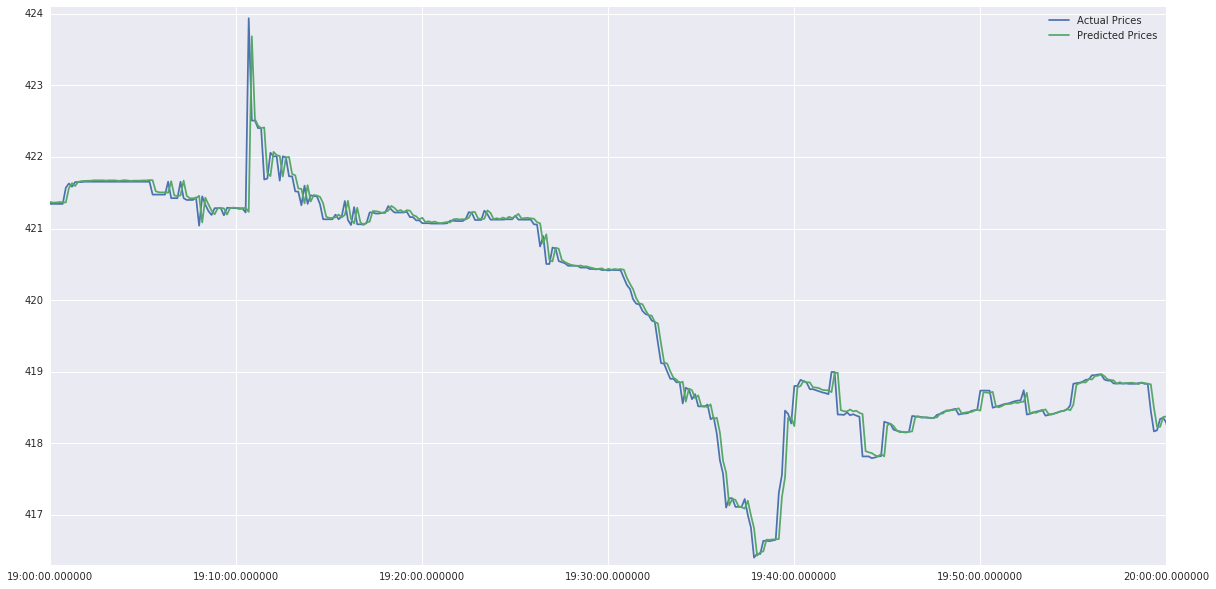

In [34]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
plt.xlim('2016-04-08 19', '2016-04-08 20')
plt.ylim(416.3, 424.1)
plt.legend()

In [35]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

0.0936933135946
0.127782261503


In [36]:
act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
accuracy = np.sum(act_pred_cmp) / len(act_ticks)
accuracy

0.52402362634382005

In [7]:
X_train = pd.DataFrame()
y_train = y[train_dates[2] : train_dates[-1]]

for i in range(2):
    colname = 'mid price ' + str(i + 1)
    X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 2)].values
    
for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
    X_train[c] = X[c].ix[1 : len(train_dates) - 1].values
    
X_train.set_index(train_dates[2:])

,mid price 1,mid price 2,ask price,bid price,mean ask price,mean bid price
2016-01-01 00:00:20,0.651821,0.651821,0.662578,0.641009,0.686037,0.650538
2016-01-01 00:00:30,0.651821,0.652255,0.662578,0.641877,0.688592,0.646125
2016-01-01 00:00:40,0.652255,0.652905,0.662578,0.643179,0.692426,0.648951
2016-01-01 00:00:50,0.652905,0.653122,0.662578,0.643613,0.688137,0.650538
2016-01-01 00:01:00,0.653122,0.653122,0.662578,0.643613,0.688137,0.650082
2016-01-01 00:01:10,0.653122,0.653122,0.662578,0.643613,0.688137,0.644213
2016-01-01 00:01:20,0.653122,0.653122,0.662578,0.643613,0.688116,0.649277
2016-01-01 00:01:30,0.653122,0.653339,0.662578,0.644047,0.687856,0.650277
2016-01-01 00:01:40,0.653339,0.653556,0.662578,0.644481,0.692079,0.648734
2016-01-01 00:01:50,0.653556,0.653773,0.662578,0.644915,0.693054,0.644234


In [8]:
X_test = pd.DataFrame()
y_test = y[test_dates[2] : test_dates[-1]]

for i in range(2):
    colname = 'mid price ' + str(i + 1)
    X_test[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(test_dates) + i - 2)].values
    
for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
    X_test[c] = X[c].ix[len(train_dates) + 1 : len(train_dates) + len(test_dates) - 1].values
    
X_test.set_index(test_dates[2:])

,mid price 1,mid price 2,ask price,bid price,mean ask price,mean bid price
2016-03-25 17:30:20,0.027636,0.027636,0.025407,0.029864,0.019807,0.034408
2016-03-25 17:30:30,0.027636,0.029155,0.027576,0.030732,0.022796,0.039820
2016-03-25 17:30:40,0.029155,0.033711,0.035817,0.031601,0.023467,0.039320
2016-03-25 17:30:50,0.033711,0.033711,0.035817,0.031601,0.023402,0.039625
2016-03-25 17:31:00,0.033711,0.033711,0.035817,0.031601,0.024204,0.040038
2016-03-25 17:31:10,0.033711,0.033711,0.035817,0.031601,0.023056,0.040581
2016-03-25 17:31:20,0.033711,0.028504,0.025407,0.031601,0.020413,0.040668
2016-03-25 17:31:30,0.028504,0.028504,0.025407,0.031601,0.019136,0.037103
2016-03-25 17:31:40,0.028504,0.027202,0.025407,0.028996,0.019049,0.034321
2016-03-25 17:31:50,0.027202,0.027636,0.025407,0.029864,0.019157,0.037147


In [19]:
clf = BayesianRidge(compute_score=True)
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [20]:
pred = clf.predict(X_test)
pd.DataFrame(pred, index = test_dates[2:])

,0
2016-03-25 17:30:20,415.979939
2016-03-25 17:30:30,416.016491
2016-03-25 17:30:40,416.113843
2016-03-25 17:30:50,416.119952
2016-03-25 17:31:00,416.120701
2016-03-25 17:31:10,416.120300
2016-03-25 17:31:20,416.009374
2016-03-25 17:31:30,415.999639
2016-03-25 17:31:40,415.971852
2016-03-25 17:31:50,415.980582


In [21]:
act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
accuracy = np.sum(act_pred_cmp) / len(act_ticks)
accuracy

0.60435332778728679